In [76]:
import h5py
from astropy import constants as const
import numpy as np
import matplotlib.pyplot as plt

from scipy import signal
#from scipy.fft import fftshift
from scipy.interpolate import CubicSpline
from pycbc.detector import Detector
from gwpy.timeseries import TimeSeries
from gwpy.detector import Channel

In [77]:
def ReadExtrapolatedMode(file, mode = (2,2), order = 2, mass = 68 * const.M_sun, radius = 400000 * const.kpc):
    """ Read in an extrapolated SXS-format gravitational waveform mode """

    l = mode[0]
    m = mode[1]
    f = h5py.File(file, 'r')
    data = f['Extrapolated_N'+str(order)+'.dir']['Y_l' + str(l) + '_m'  + str(m) + '.dat']
    time, re, im = data[:,0], data[:,1], data[:,2]
    time = time - time[0]
    
    ## Combine the real and imaginary parts of the data
    re_adj = re*const.G*mass/((const.c)**2*radius)
    im_adj = im*const.G*mass/((const.c)**2*radius)
    time_adj = time*mass*const.G/(const.c**3)
    
    #dt = 1/len(time_adj)
     
    dt = 1/2048
    times = np.arange(time_adj[0].value, time_adj[-1].value, dt)
    cs_r = CubicSpline(time_adj,re_adj)
    cs_i = CubicSpline(time_adj,im_adj)
    
    real = cs_r(times)
    imag = cs_i(times)
    
    #return time, re, im, dt
    return times, real, imag, dt

def CutTimes(time, data, TLow, TUp): 
    TLowIndex = np.where(time <= TLow)[0][-1]
    TUpIndex = np.where(time >= TUp)[0][0]
    time = time[TLowIndex:TUpIndex]
    data = data[TLowIndex:TUpIndex]
    return time, data

def Ramp(time, t_s, t_r):
    if (time < t_s):
        return 0.0
    elif time > (t_s + t_r):
        return 1.0
    else:
        t = (time - t_s)/t_r
        return t**5*(126 + t*(-420 + t*(540 + t*(-315 + 70*t))))
    
def SubtractPeakTimeMode(time, data): ###
    t_peak = time[np.argmax(np.absolute(data))]
    return time - t_peak

    

In [107]:
# File we're reading from 
rh_file = "/home/maria.okounkova/BeyondGRAnalysis/Waveforms_22/Lev2/rhOverM_Asymptotic_GeometricUnits_CoM.h5"
#rh_file = "SXS_0305/rhOverM_Asymptotic_GeometricUnits_CoM.h5"

# Open the HDF5 file in read-only mode:
rh_data = h5py.File(rh_file,'r')

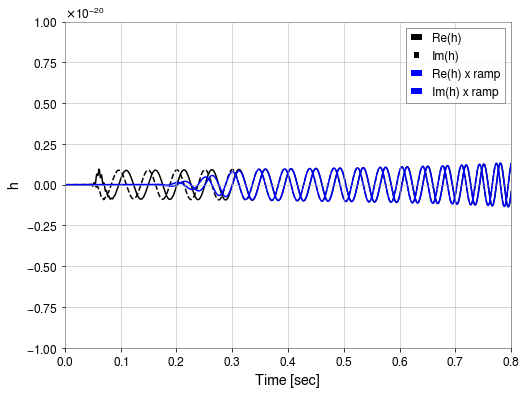

In [108]:
## Plot the data and apply the ramp function
plt.figure(figsize=(8, 6))
t, re, img, dt = ReadExtrapolatedMode(rh_file, mode = (2,2), order = 2,  mass = 68 * const.M_sun)

ramp = np.array([Ramp(time, 0.1, 0.3) for time in t])

plt.plot(t, re, color='black', label='Re(h)')
plt.plot(t, img, '--', color='black', label='Im(h)')
plt.plot(t, re * ramp, color='blue', label='Re(h) x ramp')
plt.plot(t, img * ramp, color='blue', label='Im(h) x ramp')
    
plt.xlim(0, 0.8)
plt.ylim(-1e-20, 1e-20)
plt.legend()
plt.xlabel('Time [sec]')
plt.ylabel('h')
plt.show()

## actually apply the ramp function
re = re * ramp
img = img * ramp

In [109]:
## Comput and shift h_plus and h_cross
t_gps = 1126259462.4107006 ## desired gps time
peak_time_in_segment = 8.0 ## how late in the segment do we want the peak to occur?
segment_length = 16.0 ## how long do we want the segment to be?
sample_rate = 2048

h_plus = re + img
h_cross = re - img

## shift and pad the waveform before we do anything else
t_peak = t[np.argmax(h_plus**2 + h_cross**2)]

## want the peak time to correspond to 6 seconds
shift_amount = (peak_time_in_segment - t_peak)
start_pad = int(shift_amount * 2048)
end_pad = int(sample_rate*segment_length - len(h_plus) - start_pad)

h_plus = np.pad(h_plus, (start_pad, end_pad), 'constant', constant_values=(0.0, 0.0))
h_cross = np.pad(h_cross, (start_pad, end_pad), 'constant', constant_values=(0.0, 0.0))
t = np.arange(0., segment_length, dt) + t_gps - peak_time_in_segment


t_peak =  1126259462.4107006


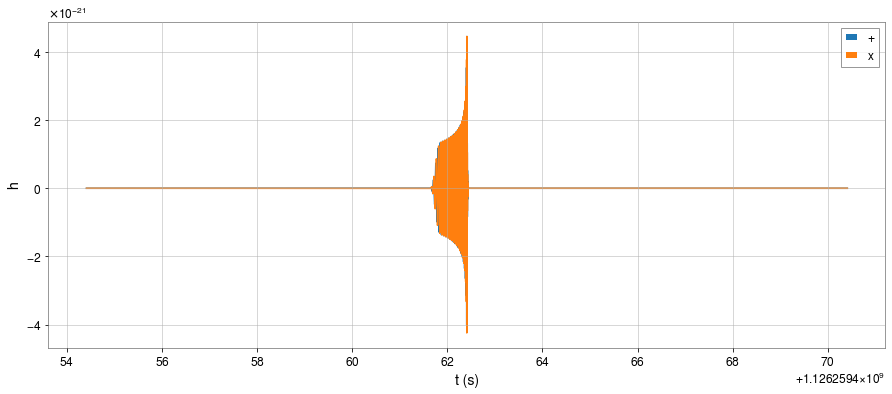

In [110]:
plt.figure(figsize = ([15, 6]))
plt.plot(t, h_plus, label = '+')
plt.plot(t, h_cross, label = 'x')
plt.xlabel('t (s)')
plt.ylabel('h')
#plt.xlim(5.5, 6.2)
plt.legend()
plt.plot

print("t_peak = ",t[np.argmax(h_plus**2 + h_cross**2)])

In [111]:
d_H1 = Detector("H1")
d_L1 = Detector("L1")

In [112]:
def ProjectToDetectors(ra, dec, pol, t0, plus, cross, time):
    '''
    ra - Right Ascension
    dec - Declination
    pol - Polarization Angle
    t0 - reference time for when signal reaches Hanford
    '''
    
    #Instantiating detector objects
    
    #The time delay of the signal between the detectors
    t_delay = d_L1.time_delay_from_detector(d_H1, ra, dec, t0)
    
    #Antenna Patterns
    Fp_H1, Fc_H1 = d_H1.antenna_pattern(ra, dec, pol, t0)
    Fp_L1, Fc_L1 = d_L1.antenna_pattern(ra, dec, pol, t0 + t_delay)
    
    #project
    h_H1 = Fp_H1*plus + Fc_H1*cross
    h_L1 = Fp_L1*plus + Fc_L1*cross
    
    #Shift times
    time_H1 = time
    time_L1 = time + t_delay
    print(t_delay)
    
    return h_H1, h_L1, time_H1, time_L1

In [113]:
strainH, strainL, timeH, timeL = ProjectToDetectors(ra=4.7614763656, dec=-0.531780006467, pol=0.310886773011, \
                                                    t0=t_gps, plus=h_plus, cross=h_cross, time=t)

0.005239059443450027


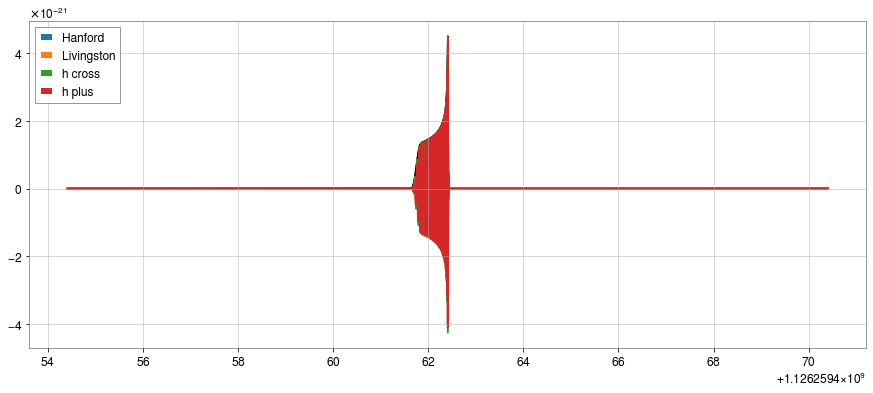

In [114]:
plt.figure(figsize = ([15, 6]))
plt.plot(timeH, strainH, label = "Hanford")
plt.plot(timeL, strainL, label = "Livingston")
plt.plot(t, np.sqrt(h_cross**2 + h_plus**2), color='black')
plt.plot(t, np.sqrt(h_cross**2 + h_plus**2), color='black')
plt.plot(t, h_cross, label='h cross')
plt.plot(t, h_plus, label='h plus')
plt.legend(loc = 2)
plt.show()

In [115]:
H1_padded = TimeSeries(strainH,sample_rate=1/dt,epoch=timeH[0],channel="H1:LDAS_STRAIN")
L1_padded = TimeSeries(strainL,sample_rate=1/dt,epoch=timeL[0],channel="L1:LDAS_STRAIN")

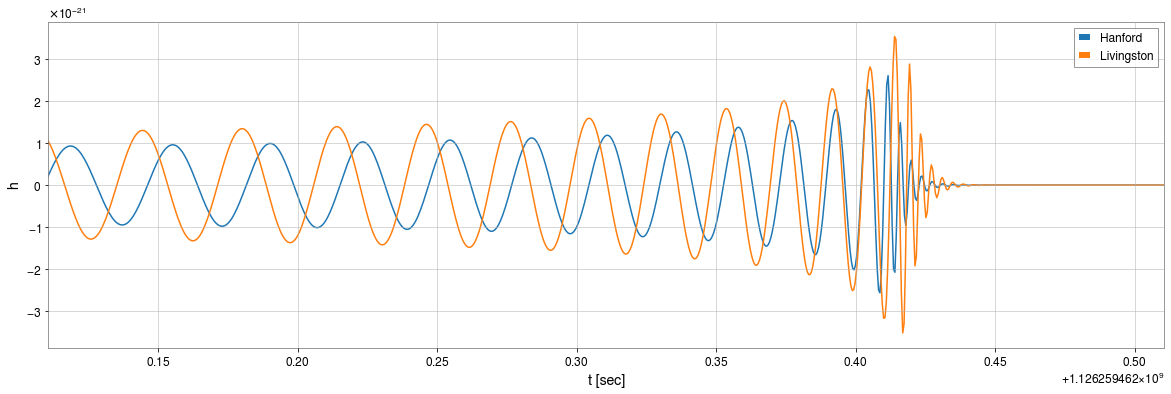

In [116]:
plt.figure(figsize = ([20, 6]))
plt.plot(H1_padded.times.value, H1_padded.value, label = 'Hanford')
plt.plot(L1_padded.times.value, L1_padded.value, label = 'Livingston')
plt.ylabel('h')
plt.xlabel('t [sec]')
plt.xlim(t_gps - 0.3, t_gps + 0.1)
plt.legend()
plt.show()

In [117]:
# Save
H1_padded.write("H1_GR.gwf")
L1_padded.write("L1_GR.gwf")

In [118]:
def PlotSeriesFromFile(plot_fft = True):

    s1 = TimeSeries.read(source = "/home/maria.okounkova/public_html/SimplerFrames/H1_GR.gwf", channel="H1:LDAS_STRAIN")
    #s1 = TimeSeries.read(source = "/home/maria.okounkova/BeyondGRAnalysis/Waveforms_22/dCS_0p0_Lev2/H-H1HWINJ_dCS_0p0.gwf", channel="H1:LDAS_STRAIN")
    t1 = s1.times

    plt.figure(figsize=(10, 8))
    
    if plot_fft:
        fft = s1.fft()
        plt.plot(fft.frequencies, np.abs(fft.value))
        plt.xlabel('Frequency [Hz]')
        plt.ylabel('h')
        plt.xlim(0, 400)
        plt.yscale('log')
        plt.axvline(25, color='black', label='25 Hz')
        plt.legend()
        plt.ylim(1e-25, 2e-21)
    
    else:
        plt.plot(t1, s1, label='H1', color='orange')
        plt.xlabel('Time [sec]')
        plt.legend()
        plt.ylabel('h')
        
    plt.show()
    

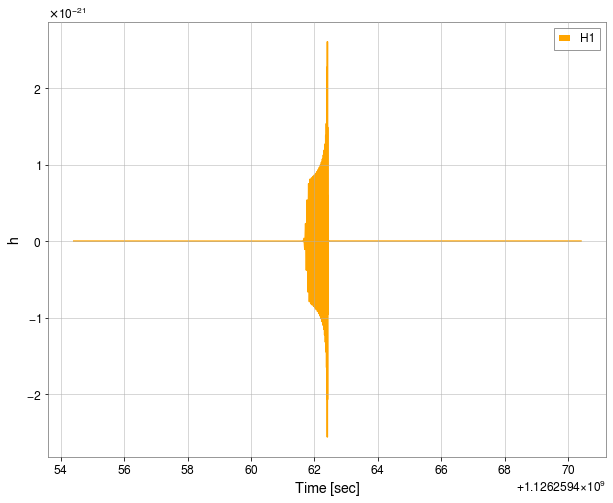

In [119]:
CompareSeries(plot_fft = False)